<a href="https://colab.research.google.com/github/antonelijr/variant_D614G/blob/main/python_variant_D614G_US.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Epidemic Growth Rates and Transmissibility of SARS-CoV-2 - USA (West Coast x East Coast)**


## Estimation of the growth rate $\lambda$ and $\mathcal{R}_0$

Consider a exponential approximation for the initial segment of the growth function $I(t)$ of the epidemics (that is, $I(t)$ isthe numeber of infected per unit of time), with growth rate $\lambda$,
$$
 I(t)=I_0 \, e^{\lambda t}
$$

By transforming to logarithmic scale we have linear equation
$$
 \log I(t) = \log I_0 + \lambda t
$$
This suggests using a simple Linear Model
$$
 y = \alpha_0 + \alpha_1 x
$$
to estimate $\lambda$ as the slope $\alpha_1$ of a regression line.

The Basic Reproduction Number $\mathcal{R}_0$ may be estimated as
$$
 \mathcal{R}_0 = 1 + \alpha_1  \, \gamma^{-1}
$$
where $\gamma^{-1}$ is the average length of time someone is infectious.

In general, it is not possible to simultaneously estimate $\alpha_1$ and $\gamma$ from epidemic time series, since these are confounded parameters (that is only a combination of both can be estimated from epidemic time series). Hence, in order to estimate $\mathcal{R}_0$ from epidemic time series on need to obtain the value of $\gamma$ by other means. Various estimates range from 7 days to 10 days.

It is important to remark that, for the purpose of estimating the growth rate $\lambda$ at the initial times, it is possible to use any derivative or any integral of $I(t)$. In fact, since $I(t)$ is essentialy an exponential function, its derivatives and integrals are constant multiples of $I(t)$ (with distinct constnats). Hence, it does not matter if one uses the actual times series for $I(t)$ or the cumulative counting, the Linar Model for estimating $\lambda$ will have the same $\alpha_1$, with possibly distinct estimates of $\alpha_0$. Since we are only intrested in $\alpha_1$ this is imaterial.



## Load the necessary Python Libraries

In [ ]:
import sys
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd 
import pandas_datareader as pdr
import random
import math
import time
import xgboost
import datetime
import operator
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from scipy.special import expit
from scipy.stats import norm
from scipy import stats


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Retreive and Load the Data
Read the data from git repository: \\
**COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University** \\
https://github.com/CSSEGISandData


In [ ]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
#deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')


## View Data 

In [ ]:
confirmed_df.head(n=5)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,743,765,773,810,823,838,845,863,877,891,900,909,932,941,949,963,972,988,1010,1024,1030,1030,1050,1065,1086,1169,1174,1162,1188,1196,1196,1206,1218,1219,1235,1241,1240,1255,1264,1266
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1499,1579,1669,1796,1914,1990,2077,2164,2423,2473,2620,2665,2727,2793,2865,2984,3056,3095,3175,3210,3263,3322,3380,3443,3502,3544,3651,3670,3710,3744,3791,3839,3877,3888,3906,3931,3957,3997,4037,4069
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,426,444,448,465,472,479,484,487,501,507,516,523,529,535,538,539,550,554,562,563,563,564,565,569,573,575,576,579,581,586,590,598,604,605,606,613,619,622,626,629
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,238,243,251,260,265,274,278,282,284,297,312,317,327,330,336,344,355,360,364,374,381,384,413,416,426,438,442,444,453,457,465,469,469,474,476,490,494,501,503,510
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,367,395,406,421,441,465,479,498,528,552,569,578,601,607,623,658,685,704,722,736,741,745,759,774,788,800,812,816,825,835,848,854,860,863,887,901,912,930,931,934


In [ ]:
confirmed_df.tail(n=5)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,7/15/20,7/16/20,7/17/20,7/18/20,7/19/20,7/20/20,7/21/20,7/22/20,7/23/20,7/24/20,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20,8/4/20,8/5/20,8/6/20,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20
3335,84056039,US,USA,840,56039.0,Teton,Wyoming,US,43.935225,-110.589080,"Teton, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,170,181,187,197,208,223,226,234,254,264,275,279,292,311,318,331,335,348,354,358,362,363,367,371,370,374,370,372,373,375,383,385,389,390,393,394,398,399,401,409
3336,84056041,US,USA,840,56041.0,Uinta,Wyoming,US,41.287818,-110.547578,"Uinta, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,208,217,219,221,221,222,223,224,227,232,232,233,235,243,245,247,254,259,262,265,267,268,272,274,274,278,277,279,278,278,277,276,276,277,278,283,283,283,283,283
3337,84090056,US,USA,840,90056.0,Unassigned,Wyoming,US,0.000000,0.000000,"Unassigned, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3338,84056043,US,USA,840,56043.0,Washakie,Wyoming,US,43.904516,-107.680187,"Washakie, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,43,43,43,43,44,44,44,45,45,45,45,45,45,45,45,46,48,49,49,49,54,58,59,69,70,77,77,79,82,86,96,97,97,100,102,104,106,106,107,108
3339,84056045,US,USA,840,56045.0,Weston,Wyoming,US,43.839612,-104.567488,"Weston, Wyoming, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,3,3,4,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,6,5,5,5,5,7,7,8,8,12,0,11,11,11


## Filter the approprite subset of US states

Select the counties of the East and West Coast to create a new Data Frame (Uncomment lines with "#Uncomment to remove outlier" to remove county)

In [ ]:
last_column = list(confirmed_df.columns)[confirmed_df.shape[1]-1]
confirmed_df = confirmed_df[confirmed_df[last_column] != 0]
W_coast = ['California','Washington','Oregon']
E_coast = ['New York','Virginia','Connecticut']
#confirmed_df = confirmed_df[confirmed_df.Admin2 != "New York"]                           #Uncomment to remove outlier
#confirmed_df = confirmed_df[confirmed_df.Admin2 != "Los Angeles"]                        #Uncomment to remove outlier 
confirmed_W_df = (confirmed_df[confirmed_df['Province_State'].isin(W_coast)])
confirmed_E_df = (confirmed_df[confirmed_df['Province_State'].isin(E_coast)])


Clean and reset the new Data Frames

In [ ]:
length_confirmed_W =len(confirmed_W_df.Admin2)
length_confirmed_E =len(confirmed_E_df.Admin2)
confirmed_W_df = confirmed_W_df.reset_index()
confirmed_E_df = confirmed_E_df.reset_index()
confirmed_W_df = confirmed_W_df.drop([length_confirmed_W-1])
confirmed_E_df = confirmed_E_df.drop([length_confirmed_E-1])
cols_W = confirmed_W_df[['Admin2','Province_State']].apply(lambda x: '-'.join(x), axis=1).values
cols_E = confirmed_E_df[['Admin2','Province_State']].apply(lambda x: '-'.join(x), axis=1).values


Fix the range of the time series. \\
**Obs:** The data is daily updated at the original repository and this script retrieves the latest version.

In [ ]:
first_date = '2/18/20'
last_date = list(confirmed_df.columns)[confirmed_df.shape[1]-1]


Extract the time series within the range

In [ ]:
# West coast
confirmed_W_df = confirmed_W_df.loc[:, first_date : last_date]

# East coast
confirmed_E_df = confirmed_E_df.loc[:, first_date : last_date]


Create new Data Frames with the counties as columns and the dates as rows

In [ ]:
# West coast
cum_W_df = confirmed_W_df.transpose().copy(deep=True)
cum_W_df.columns = cols_W
cum_W_df.columns = cum_W_df.columns.str.replace(' ', '_')

# East coast
cum_E_df = confirmed_E_df.transpose().copy(deep=True)
cum_E_df.columns = cols_E
cum_E_df.columns = cum_E_df.columns.str.replace(' ', '_')

Side by side plot the time series of each county

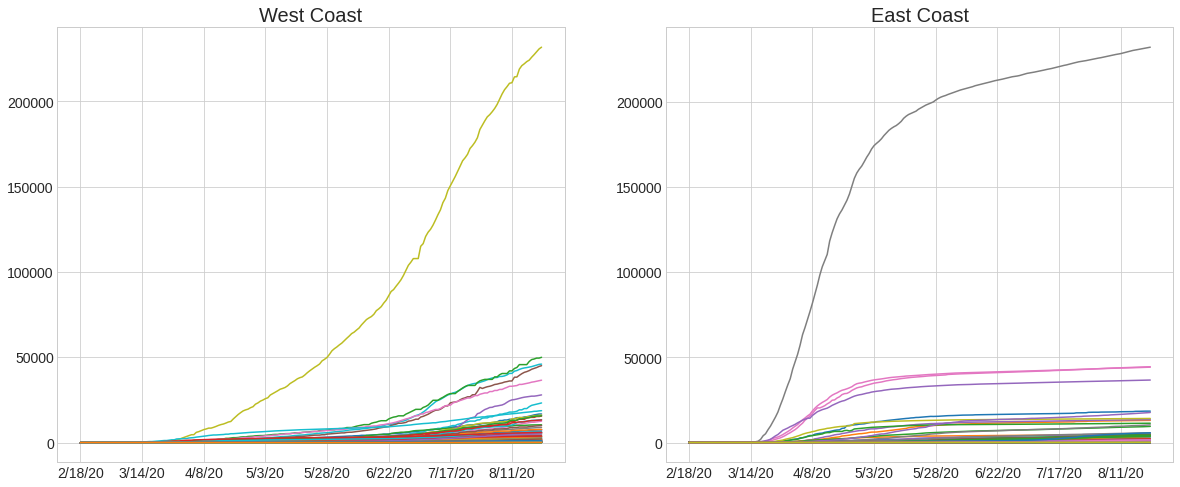

In [ ]:
plt.rcParams['figure.figsize'] = (8,6)
plt.style.use('seaborn-whitegrid')
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(20,8))
cum_W_df.plot(ax = axes[0],legend=False,title="West Coast")
cum_E_df.plot(ax = axes[1],legend=False, title="East Coast")


The time series from the repository are the cumulative counting.
In order to use the actual daily counting it is necessary to reverse the cumulative sum of the time series. Uncoment below to compute the daily counting. \\
**Obs:** as remarked before, for the purpose of estimating the growth rate for the initial segment of the epidemics growth, it is possible to use the cumulative countig instead of the daily counting.

In [ ]:
# Uncomnt below to reverse the cumulative time series

# West coast
total_W_df = cum_W_df.copy(deep=True)
#total_W_df.loc[:, cols_W ] = total_W_df.loc[:, cols_W ].diff().fillna(0).astype(int)

# East coast
total_E_df = cum_E_df.copy(deep=True)
#total_E_df.loc[:, cols_E ] = total_E_df.loc[:, cols_E ].diff().fillna(0).astype(int)


## Transform the data to Logarithmic Scale

Apply logarithm transformation the time series

In [ ]:
# West coast
log_W_df = total_W_df.apply(np.log).replace([np.inf, -np.inf], 0).copy(deep=True)

# East coast
log_E_df = total_E_df.apply(np.log).replace([np.inf, -np.inf], 0).copy(deep=True)


Side by side plot of the (initial segment) log transformed time series

(0.0, 50.0)

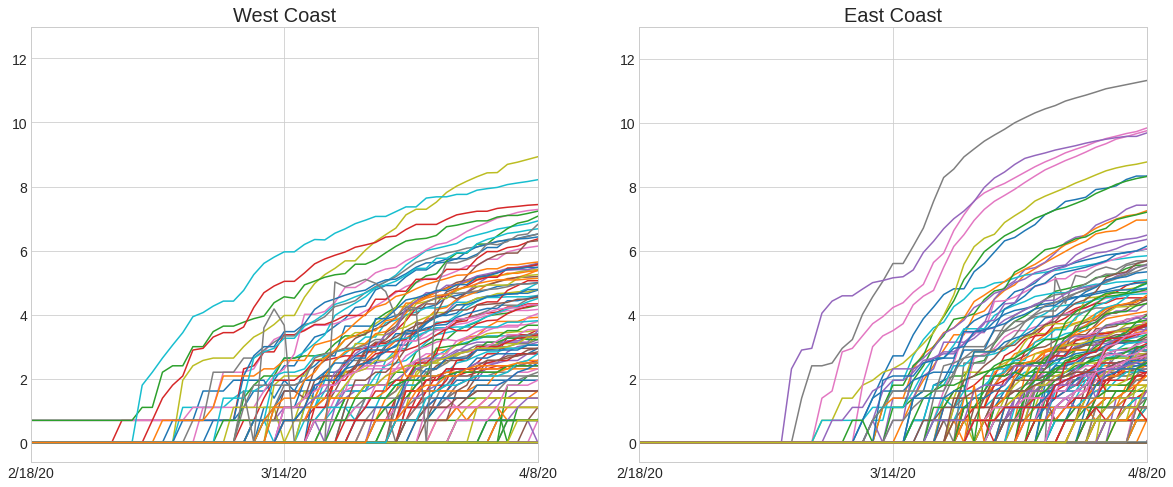

In [ ]:
plt.rcParams['figure.figsize'] = (8,6)
plt.style.use('seaborn-whitegrid')
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(20,8))
lwp = log_W_df.plot(ax = axes[0],legend=False,title="West Coast")
lep = log_E_df.plot(ax = axes[1],legend=False,title="East Coast")
lwp.set_xlim(0,50)
lep.set_xlim(0,50)

## Computation Linear Models
Define initial segment of time series

In [ ]:
# We consider an initial segment of 3 weeks
num_days = 21
x = np.arange(num_days, dtype=float).reshape((num_days, 1))

Example of Linear Model computation

In [ ]:
y_W1 = log_W_df['San_Francisco-California'][log_W_df.index.get_loc(log_W_df['San_Francisco-California'].ne(0).idxmax()):log_W_df.index.get_loc(log_W_df['San_Francisco-California'].ne(0).idxmax())+num_days]
y_E1 = log_E_df['Columbia-New_York'][log_E_df.index.get_loc(log_E_df['Columbia-New_York'].ne(0).idxmax()):log_E_df.index.get_loc(log_E_df['Columbia-New_York'].ne(0).idxmax())+num_days]


Compute Linear Models using standard regression

In [ ]:
lm_W1 = LinearRegression().fit(x,y_W1)
lm_E1 = LinearRegression().fit(x,y_E1)


Plot the Linear Model fitting

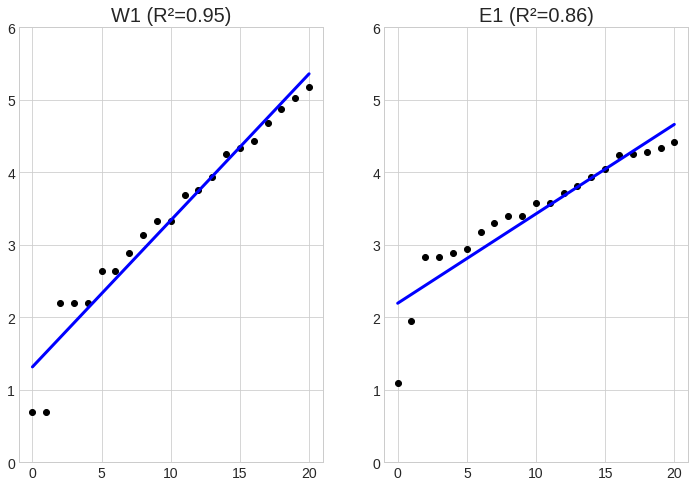

In [ ]:
plt.rcParams['figure.figsize'] = (12,8)
plt.style.use('seaborn-whitegrid')

plt.subplot(1, 2, 1)
plt.title('W1'+" (R²="+'%.2f' % r2_score(y_W1,lm_W1.predict(x))+")")
plt.ylim(0,6)
plt.plot(x, lm_W1.predict(x), color='blue', linewidth=3)
plt.scatter(x, y_W1,  color='black')

plt.subplot(1, 2, 2)
plt.title('E1'+" (R²="+'%.2f' % r2_score(y_E1,lm_E1.predict(x))+")")
plt.ylim(0,6)
plt.plot(x, lm_E1.predict(x), color='blue', linewidth=3)
plt.scatter(x, y_E1,  color='black')


## Computation of summary statistics of Linear Model

In [ ]:
# Function for the computation of summary statistics 
def lm_summary(y):
  number_days=len(y)
  x = np.arange(number_days, dtype=float).reshape((number_days, 1))
  lm = LinearRegression().fit(x,y)
  params = np.append(lm.intercept_,lm.coef_)
  predictions = lm.predict(x)
  newX = pd.DataFrame({"Constant":np.ones(len(x))}).join(pd.DataFrame(x))
  MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))
  var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
  sd_b = np.sqrt(var_b)
  ts_b = params/sd_b
  p_values = [2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]
  #sd_b = np.round(sd_b,4)
  #ts_b = np.round(ts_b,4)
  #p_values = np.round(p_values,4)
  #params = np.round(params,4)
  names = ['\u03B1'+'\u2080','\u03B1'+'\u2081']
  myDF3 = pd.DataFrame()
  myDF3["coeff"],myDF3["value"],myDF3["std_err"],myDF3["t_stat"],myDF3["p-value"],myDF3["MSE"] = [names,params,sd_b,ts_b,p_values,MSE]
  return myDF3


Example of summary statistics

In [ ]:
print(y_W1.name,"\n",lm_summary(y_W1))
print("\n")
print(y_E1.name,"\n",lm_summary(y_E1))
print("\n")


San_Francisco-California 
   coeff     value   std_err     t_stat       p-value       MSE
0    α₀  1.315933  0.126011  10.443009  1.518838e-09  0.089463
1    α₁  0.202222  0.010779  18.760837  3.641532e-14  0.089463


Columbia-New_York 
   coeff     value  std_err     t_stat       p-value       MSE
0    α₀  2.194079  0.13502  16.250057  5.451195e-13  0.102712
1    α₁  0.123416  0.01155  10.685768  1.025386e-09  0.102712




## Estimation of $\mathcal{R}_0$
Estimates $\mathcal{R}_0$ from the coefficient $\alpha_1$ and the average length of time someone is infectious $\gamma^{-1}$, given by
$$
 \mathcal{R}_0 = 1 + \alpha_1 \, \gamma^{-1}
$$
Note that we have to get the value of $\gamma^{-1}$ from other source and thus it will not be used in the rest of the analysis.


In [ ]:
# Function for computing R_0 from the slope and gamma inverse
def r_naught(alpha,inv_gamma):
  return 1+alpha[0]*inv_gamma


Example of computation of R_0

In [ ]:
g_1 = 7 #value of \gamma^{-1}
print("W1:",'%.2f' % r_naught(lm_W1.coef_,g_1))
print("E1:",'%.2f' % r_naught(lm_E1.coef_,g_1))


W1: 2.42
E1: 1.86


## Logistic Model

In [ ]:
# Early start is until 3/18/20 -> early_start = 29
early_start = 29
cols = ['alpha_1','D0G1']
lst1 = []
lst1_p = []
counter = 0

x = np.arange(num_days, dtype=float).reshape((num_days, 1))

start_point = 0
for j in log_W_df.columns:
  start_point = log_W_df.index.get_loc(log_W_df[j].ne(0).idxmax())
  if (len(log_W_df[j])-start_point >= num_days) and (start_point <= early_start):
    y_W = log_W_df[j][start_point:start_point+num_days]
    lm_W = LinearRegression().fit(x,y_W)
    if (lm_W.coef_[0] > 0):
      lst1.append([lm_W.coef_[0], 0])
      lst1_p.append([np.nan_to_num(lm_summary(y_W)['p-value'][1]),r2_score(y_W,lm_W.predict(x))])
  counter=counter+1

start_point = 0
for j in log_E_df.columns:
  start_point = log_E_df.index.get_loc(log_E_df[j].ne(0).idxmax())
  if (len(log_E_df[j])-start_point >= num_days) and (start_point <= early_start):
    y_E = log_E_df[j][start_point:start_point+num_days]
    lm_E = LinearRegression().fit(x,y_E)
    if (lm_E.coef_[0] > 0):
      lst1.append([lm_E.coef_[0], 1])
      lst1_p.append([np.nan_to_num(lm_summary(y_E)['p-value'][1]),r2_score(y_E,lm_E.predict(x))])
  counter = counter+1

early_gr_df = pd.DataFrame(lst1, columns=cols)

# Late start is after 3/17/20 -> late_start = 28
late_start = 28
cols = ['alpha_1','D0G1']
lst2 = []
lst2_p = []
counter = 0

x = np.arange(num_days, dtype=float).reshape((num_days, 1))

start_point = 0
for j in log_W_df.columns:
  start_point = log_W_df.index.get_loc(log_W_df[j].ne(0).idxmax())
  if (len(log_W_df[j])-start_point >= num_days) and (start_point >= late_start):
    y_W = log_W_df[j][start_point:start_point+num_days]
    lm_W = LinearRegression().fit(x,y_W)
    if (lm_W.coef_[0] > 0):
      lst2.append([lm_W.coef_[0], 0])
      lst2_p.append([np.nan_to_num(lm_summary(y_W)['p-value'][1]),r2_score(y_W,lm_W.predict(x))])
  counter=counter+1

start_point = 0
for j in log_E_df.columns:
  start_point = log_E_df.index.get_loc(log_E_df[j].ne(0).idxmax())
  if (len(log_E_df[j])-start_point >= num_days) and (start_point >= late_start):
    y_E = log_E_df[j][start_point:start_point+num_days]
    lm_E = LinearRegression().fit(x,y_E)
    if (lm_E.coef_[0] > 0):
      lst2.append([lm_E.coef_[0], 1])
      lst2_p.append([np.nan_to_num(lm_summary(y_E)['p-value'][1]),r2_score(y_E,lm_E.predict(x))])
  counter = counter+1

late_gr_df = pd.DataFrame(lst2, columns=cols)

Plot the time series of each county

Text(0, 0.5, '$East=0,\\;West=1$')

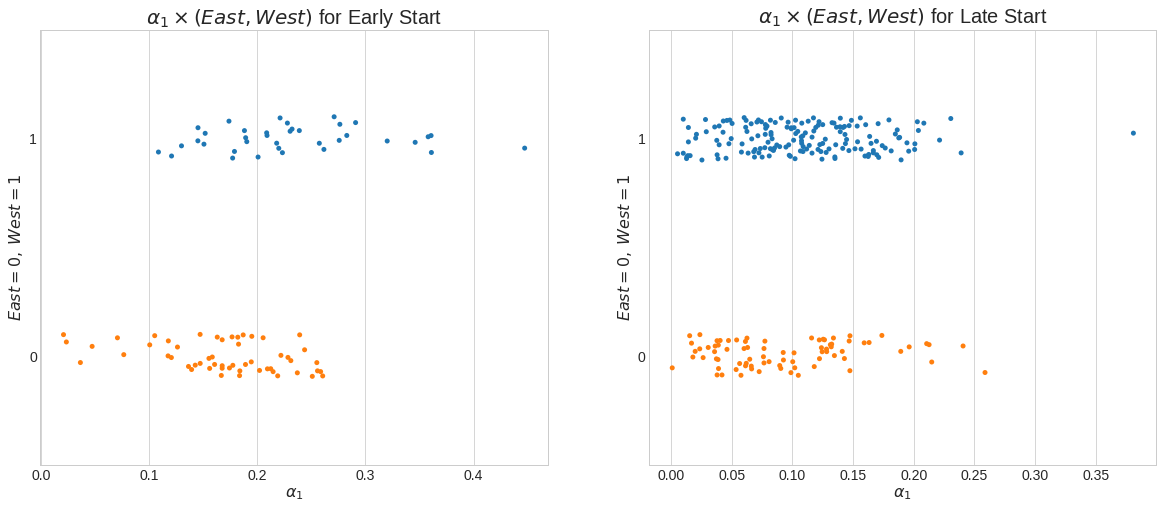

In [ ]:
plt.rcParams['figure.figsize'] = (12,8)
plt.style.use('seaborn-whitegrid')
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(20,8))
#sns.boxplot(ax = axes[0],y="D0G1", x="alpha_1", data=early_gr_df, orient="h", order=[1,0])
ax0 = sns.stripplot(ax = axes[0], y="D0G1", x="alpha_1", data=early_gr_df, jitter=True, orient="h", order=[1,0])
#sns.boxplot(ax = axes[1],y="D0G1", x="alpha_1", data=late_gr_df, orient="h", order=[1,0])
ax1 = sns.stripplot(ax = axes[1], y="D0G1", x="alpha_1", data=late_gr_df, jitter=True, orient="h", order=[1,0])

ax0.set_title(r'$\alpha_1 \times (East,West)$'+" for Early Start")
ax0.set_xlabel(r'$\alpha_1$')
ax0.set_ylabel(r'$East=0,\;West=1$')
ax1.set_title(r'$\alpha_1 \times (East,West)$'+" for Late Start")
ax1.set_xlabel(r'$\alpha_1$')
ax1.set_ylabel(r'$East=0,\;West=1$')

Computation of Logistic Model

In [ ]:
x=np.array(early_gr_df.alpha_1).reshape(-1,1)
y=early_gr_df.D0G1
early_lr = LogisticRegression(fit_intercept = True, C=1e9)
early_lr.fit(x, y)


LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
x=np.array(late_gr_df.alpha_1).reshape(-1,1)
y=late_gr_df.D0G1
late_lr = LogisticRegression(fit_intercept = True, C=1e9)
late_lr.fit(x, y)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Plot the Logistic curve

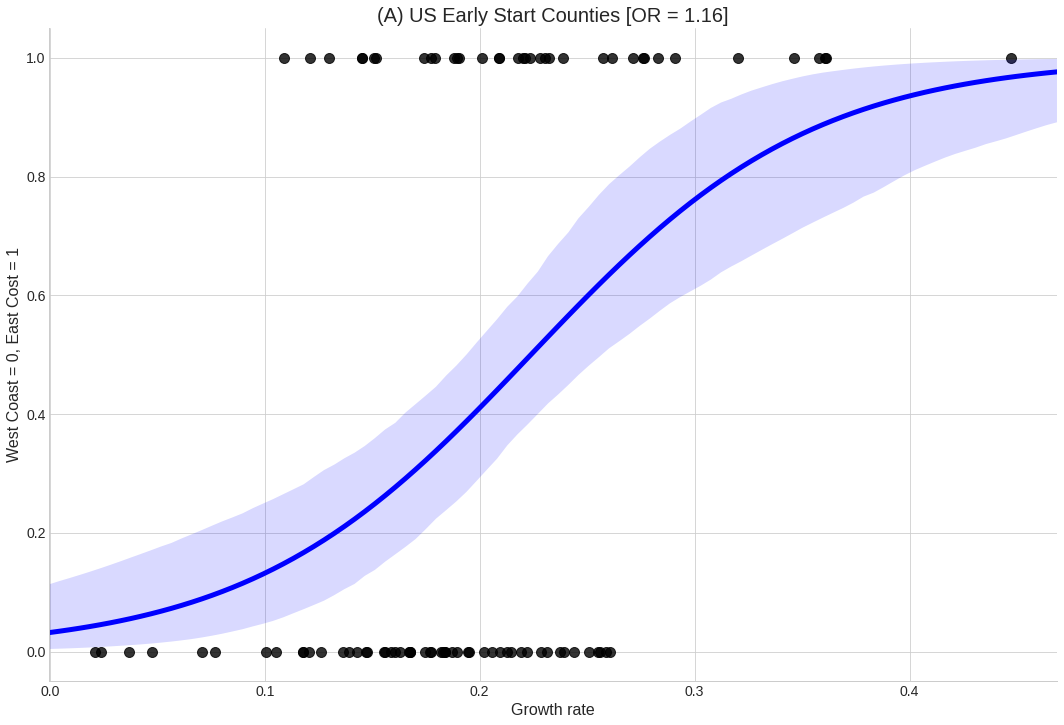

In [ ]:
plt.style.use('seaborn-whitegrid')

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

lm = sns.lmplot(y="D0G1", x="alpha_1", data=early_gr_df, logistic=True, height=10, aspect=1.5, truncate=False, line_kws={'color':'blue',"lw":5}, scatter_kws={'color': 'black', "s": 100})

#X_test = np.linspace(-0.01, 0.45, 300)
#loss = expit(X_test * early_lr.coef_ + early_lr.intercept_).ravel()
#plt.plot(X_test, loss, color='red', linewidth=3)

plt.title("(A) US Early Start Counties [OR = 1.16]")
plt.xlabel("Growth rate")
plt.ylabel("West Coast = 0, East Cost = 1")
plt.show()


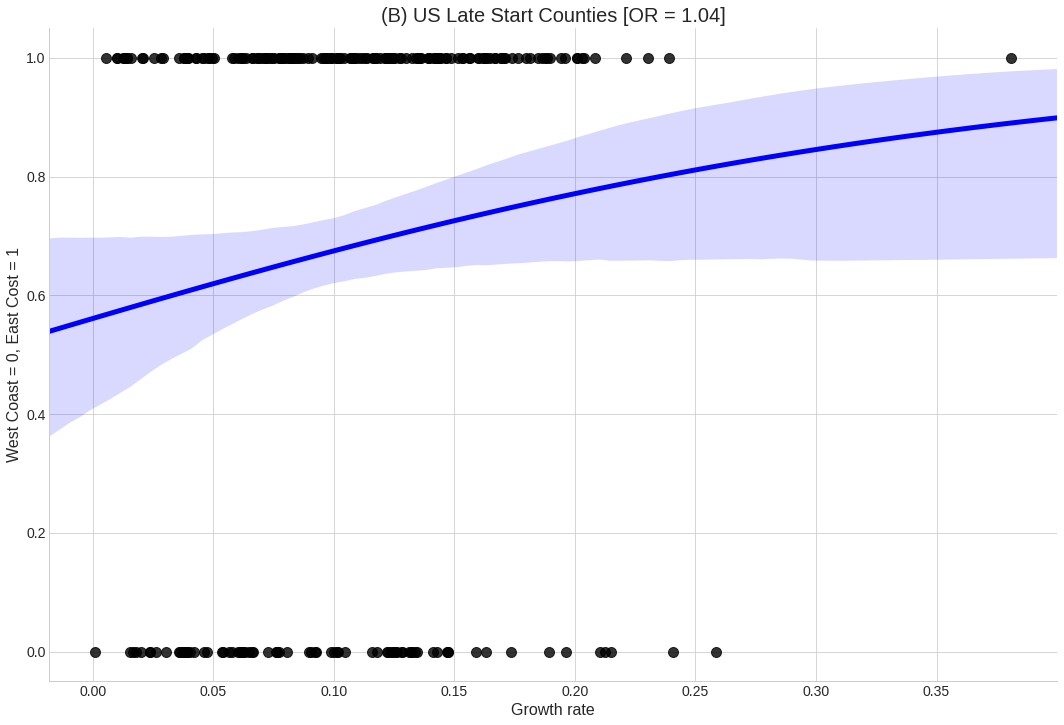

In [ ]:
plt.style.use('seaborn-whitegrid')

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

lm = sns.lmplot(y="D0G1", x="alpha_1", data=late_gr_df, logistic=True, height=10, aspect=1.5, truncate=False, line_kws={'color':'blue',"lw":5}, scatter_kws={'color': 'black', "s": 100})

#X_test = np.linspace(-0.01, 0.45, 300)
#loss = expit(X_test * early_lr.coef_ + early_lr.intercept_).ravel()
#plt.plot(X_test, loss, color='red', linewidth=3)

plt.title("(B) US Late Start Counties [OR = 1.04]")
plt.xlabel("Growth rate")
plt.ylabel("West Coast = 0, East Cost = 1")
plt.show()

## Computation of the summary statistics of Logistic Model

In [ ]:
# Function for the computation of summary statistics of Logistic Model
def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(x)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p

Print summary statistics. \\
We have to compute a correct the Odds Ratio (OR) because of the scale of our independent variable "alpha_1". A logistic regression coefficient represents the change in the dependent binary variable "D0G1" relative to a 1 unit change in the respective independent variable "alpha_1". Since our independet variable has a range ([0.0; 0.5] or [0.0; 0.25]) in the interval [0, 1], we must normalize the raw "Log OR" (or normalize the independent variable "alpha_1") so that it is in the same range as the independent variable. In both cases this amounts to diving the raw Log OR (or multiplying the indendent variable) by 100 before taking the exponential.


In [ ]:
# Print p-value, corrected Log OR and corrected OR
print("Statistics of the Slope from the Logistic Model:")
print("p-value: ",logit_pvalue(early_lr, np.array(early_gr_df.alpha_1).reshape(-1,1))[1])
print("Corrected Log OR: ",early_lr.coef_[0][0]/100)
print("Corrected OR: ",np.exp(early_lr.coef_[0][0]/100))
print("\n")

# Compare with statsmodels with re-scaled (100x) data
import statsmodels.api as sm
sm_model = sm.Logit(early_gr_df.D0G1, sm.add_constant(100*np.array(early_gr_df.alpha_1).reshape(-1,1))).fit(disp=0)
print("P-values of the model with re-scaled data:")
print(sm_model.pvalues)
print("\n")
sm_model.summary()

Statistics of the Slope from the Logistic Model:
p-value:  0.0003639583487209386
Corrected Log OR:  0.15213529299504241
Corrected OR:  1.1643177498121968


P-values of the model with re-scaled data:
const    0.000130
x1       0.000364
dtype: float64




<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   D0G1   No. Observations:                   91
Model:                          Logit   Df Residuals:                       89
Method:                           MLE   Df Model:                            1
Date:                Mon, 24 Aug 2020   Pseudo R-squ.:                  0.1494
Time:                        21:34:05   Log-Likelihood:                -52.292
converged:                       True   LL-Null:                       -61.479
Covariance Type:            nonrobust   LLR p-value:                 1.815e-05
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.4049      0.890     -3.827      0.000      -5.149      -1.661
x1             0.1521      0.043      3.565      0.000       0.068       0.236
==============================================================================
"""

In [ ]:
# Print p-value, corrected Log OR and corrected OR
print("Statistics of the Slope from the Logistic Model:")
print("p-value: ",logit_pvalue(late_lr, np.array(late_gr_df.alpha_1).reshape(-1,1))[1])
print("Corrected Log OR: ",late_lr.coef_[0][0]/100)
print("Corrected OR: ",np.exp(late_lr.coef_[0][0]/100))
print("\n")

# Compare with statsmodels with re-scaled (100x) data
import statsmodels.api as sm
sm_model = sm.Logit(late_gr_df.D0G1, sm.add_constant(100*np.array(late_gr_df.alpha_1).reshape(-1,1))).fit(disp=0)
print("P-values of the model with re-scaled data:")
print(sm_model.pvalues)
print("\n")
sm_model.summary()

Statistics of the Slope from the Logistic Model:
p-value:  0.05521649338103396
Corrected Log OR:  0.04850960984829186
Corrected OR:  1.0497054592820705


P-values of the model with re-scaled data:
const    0.387947
x1       0.055217
dtype: float64




<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   D0G1   No. Observations:                  244
Model:                          Logit   Df Residuals:                      242
Method:                           MLE   Df Model:                            1
Date:                Mon, 24 Aug 2020   Pseudo R-squ.:                 0.01252
Time:                        21:34:11   Log-Likelihood:                -151.72
converged:                       True   LL-Null:                       -153.64
Covariance Type:            nonrobust   LLR p-value:                   0.04980
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2456      0.284      0.863      0.388      -0.312       0.803
x1             0.0485      0.025      1.917      0.055      -0.001       0.098
==============================================================================
"""

Plot the $p$-values and $R^2$ of linear regressions 

In [ ]:
early_p_gr_df = pd.DataFrame(lst1_p, columns=['p','R'])
late_p_gr_df = pd.DataFrame(lst2_p, columns=['p','R'])


early_p_gr_df.drop(early_p_gr_df.loc[early_p_gr_df['R']<0.6].index, inplace=True)
late_p_gr_df.drop(late_p_gr_df.loc[late_p_gr_df['R']<0.6].index, inplace=True)

Text(0, 0.5, '$-\\log_{10}(p)$')

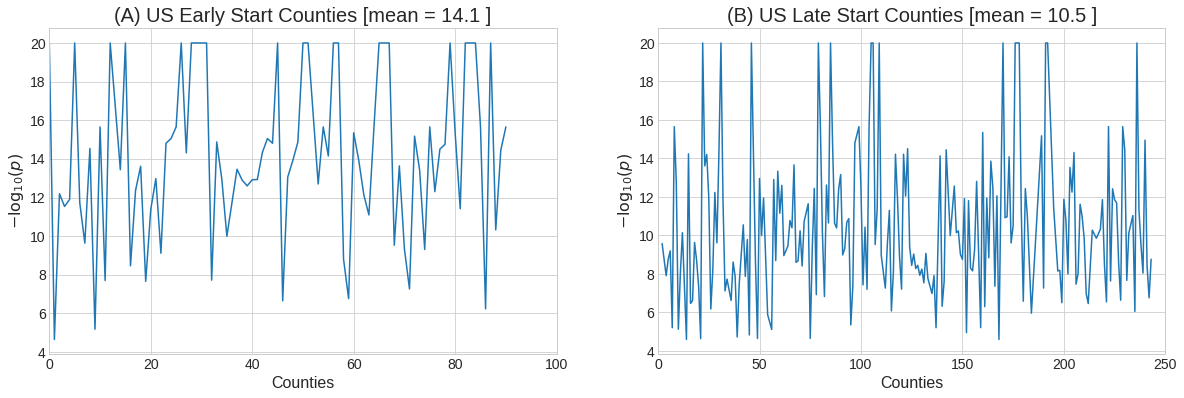

In [ ]:
plt.rcParams['figure.figsize'] = (20,6)
plt.style.use('seaborn-whitegrid')

x = np.round(np.mean(-np.log10(early_p_gr_df.p.replace(0, 1e-20))),1)
y = np.round(np.mean(-np.log10(late_p_gr_df.p.replace(0, 1e-20))),1)

plt.subplot(1, 2, 1)
plt.xlim(0,100)
plt.title('(A) US Early Start Counties [mean = '+str(x)+' ]')
plt.plot(-np.log10(early_p_gr_df.p.replace(0, 1e-20)))
plt.xlabel("Counties")
plt.ylabel(r'$-\log_{10}(p)$')

plt.subplot(1, 2, 2)
plt.xlim(0,250)
plt.title('(B) US Late Start Counties [mean = '+str(y)+' ]')
plt.plot(-np.log10(late_p_gr_df.p.replace(0, 1e-20)))
plt.xlabel("Counties")
plt.ylabel(r'$-\log_{10}(p)$')


Text(0, 0.5, '$R^2$')

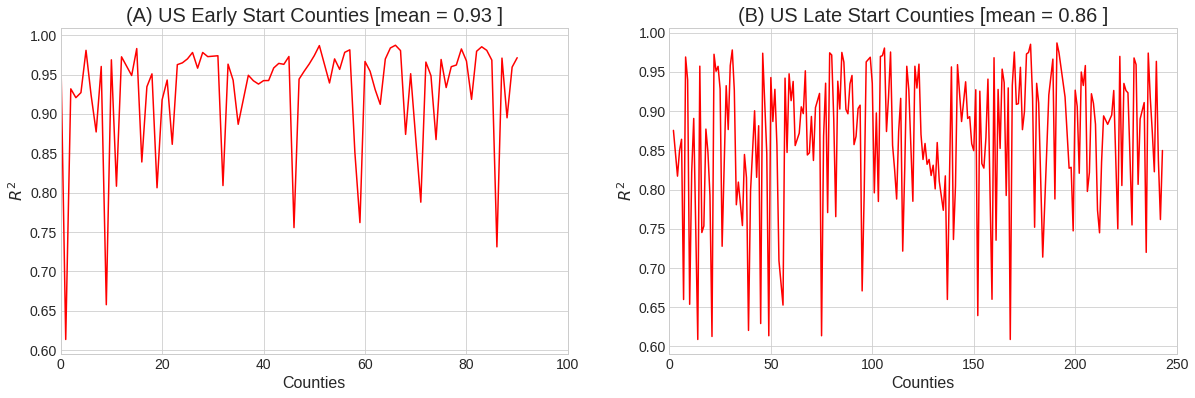

In [ ]:
plt.rcParams['figure.figsize'] = (20,6)
plt.style.use('seaborn-whitegrid')

x = np.round(np.mean(early_p_gr_df.R),2)
y = np.round(np.mean(late_p_gr_df.R),2)

plt.subplot(1, 2, 1)
plt.xlim(0,100)
plt.title('(A) US Early Start Counties [mean = '+str(x)+' ]')
plt.plot(early_p_gr_df.R, color='red')
plt.xlabel("Counties")
plt.ylabel(r'$R^2$')

plt.subplot(1, 2, 2)
plt.xlim(0,250)
plt.title('(B) US Late Start Counties [mean = '+str(y)+' ]')
plt.plot(late_p_gr_df.R, color='red')
plt.xlabel("Counties")
plt.ylabel(r'$R^2$')